# Predicting House Prices in Ames, Iowa

#### Data Source: Public dataset from Kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
#### Author: Emma Ren
#### Date: July 2017



In [70]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.decomposition import PCA
import warnings
import time
warnings.filterwarnings('ignore')

In [71]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("The train dataset has %d observations and %d features" % train.shape)
print("The test dataset has %d observations and %d features" % test.shape)

The train dataset has 1460 observations and 81 features
The test dataset has 1459 observations and 80 features


In [72]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Check out numeric features

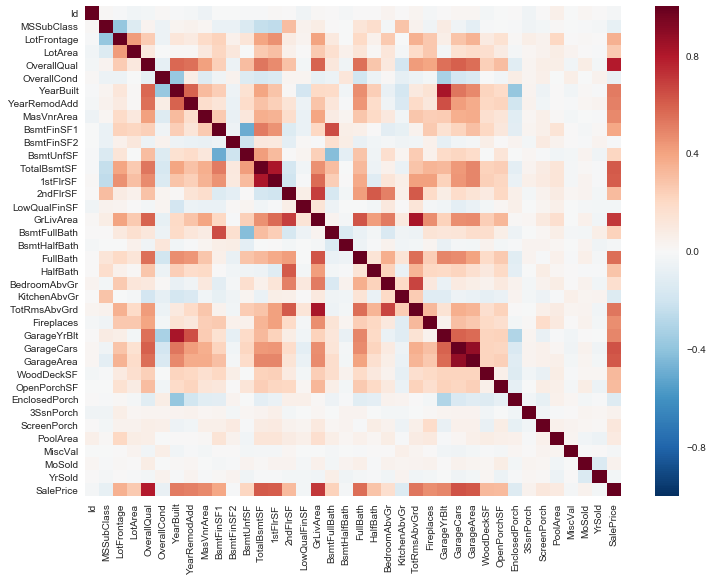

In [73]:
# Check numeric feature correlations using Heatmap
# Correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1.0, square=False)

It seems that the following numeric features are highly related to sale price:
OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, Fullbath, TotRmsAbvGrd, GarageCars,GarageArea.
Create a zoomed heatmap to take a loser look at those vars.

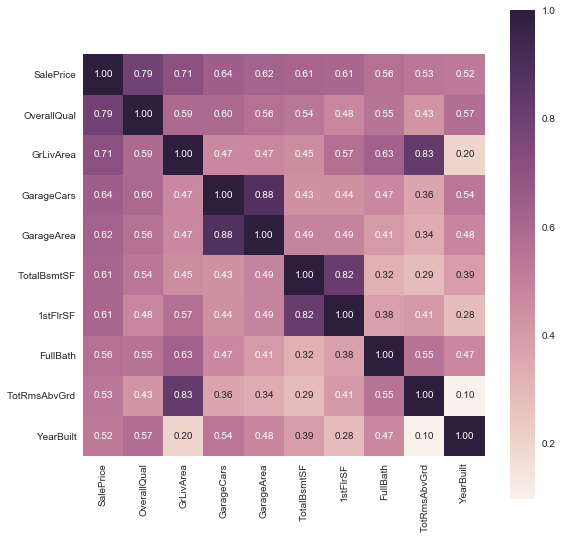

In [74]:
# Saleprice correlation matrix (zoomed heat map)
k=10
top_cor_feats =corrmat['SalePrice'].nlargest(k).index
cm=np.corrcoef(train[top_cor_feats].values.T)
plt.figure(figsize=(9,9))
sns.heatmap(cm,cbar=True,annot= True,square=True,fmt='.2f',annot_kws={'size':10},xticklabels=top_cor_feats.values,\
            yticklabels=top_cor_feats.values)

Three pairs of features have the colinearity issue: GarageCars vs GarageArea, TotalBsmtSF vs 1stFlrSF, and GrLivArea vs TotRmsAbvGrd; Those are pretty analogous features. I would keep GarageCars, GrLivArea, and TotalBsmtSF since their correlation to SalePrice is slightly higher 

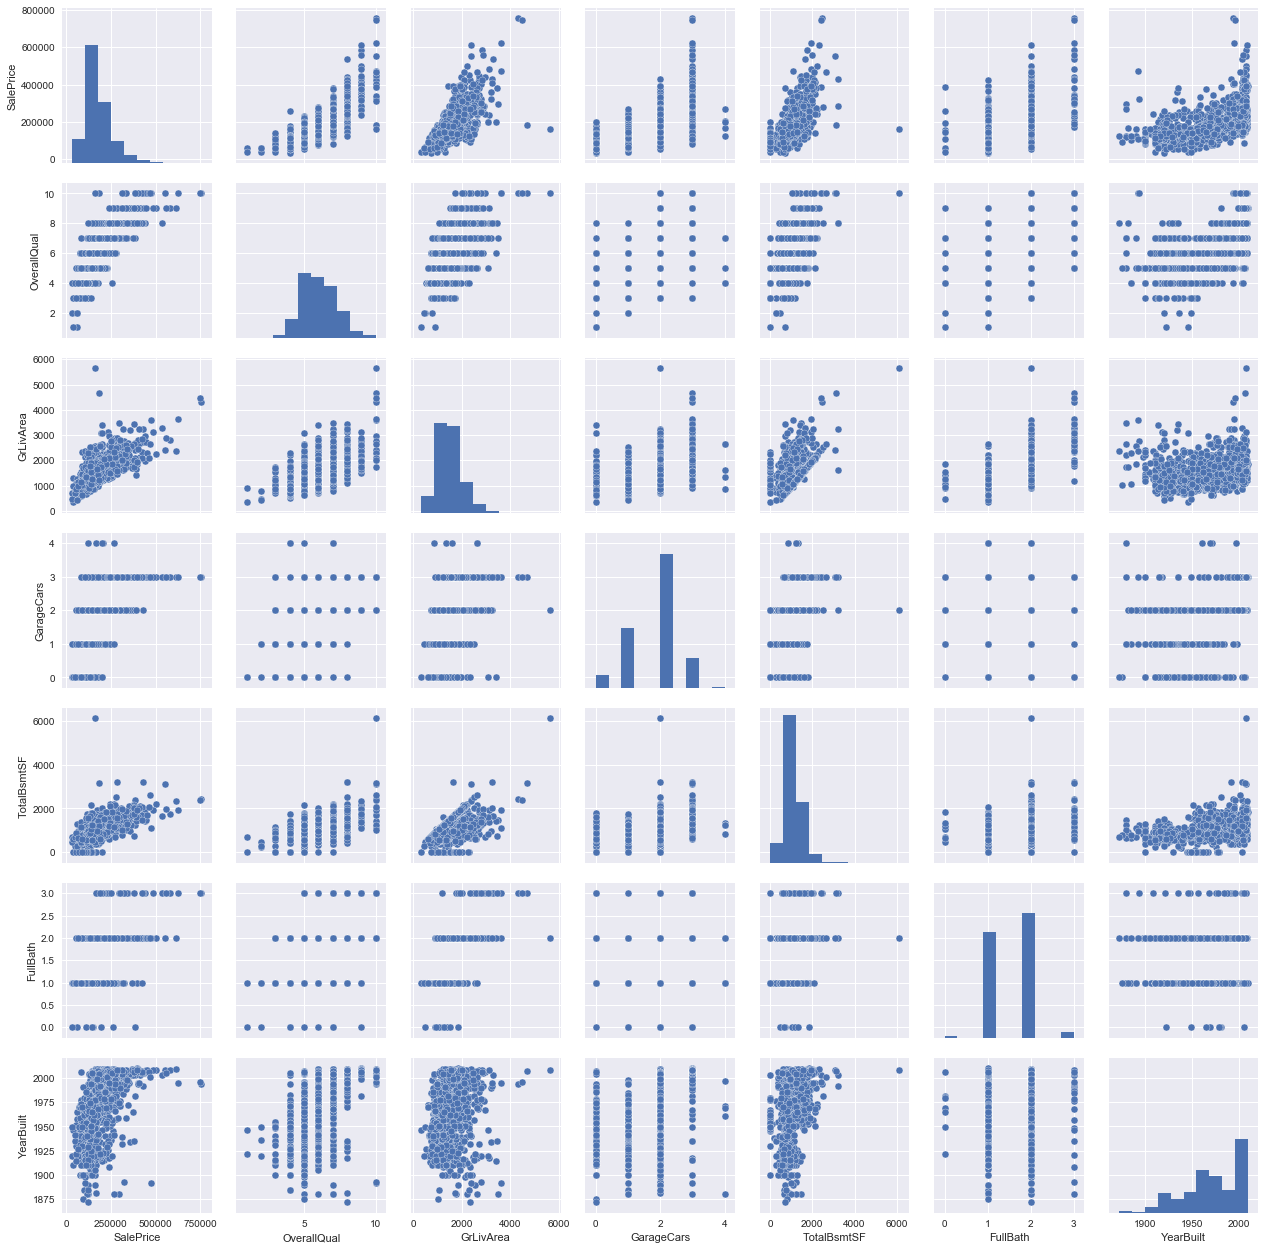

In [75]:
# Check covariants via pairplot
important_nums =["SalePrice","OverallQual","GrLivArea","GarageCars","TotalBsmtSF", "FullBath","YearBuilt"]
sns.pairplot(train[important_nums])

A couple of findings:

1) None of the features closes to normal distribution. Transformation is needed;

2) All features are positively correlated to sale price;

3) Some outliers can be found. For example, the dots representing extreme large living space in both GrLivArea and TotalBsmtSF

## Check out categorical features

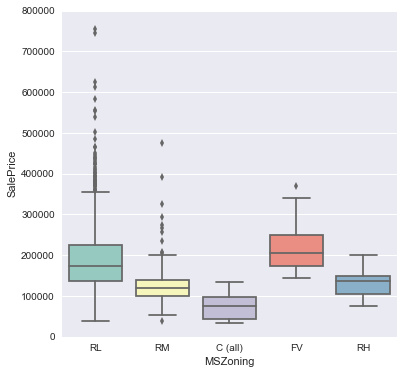

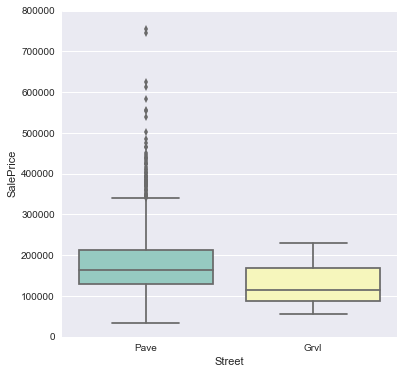

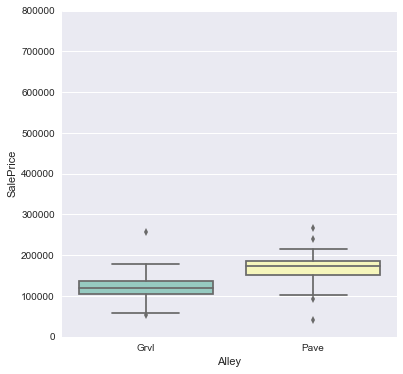

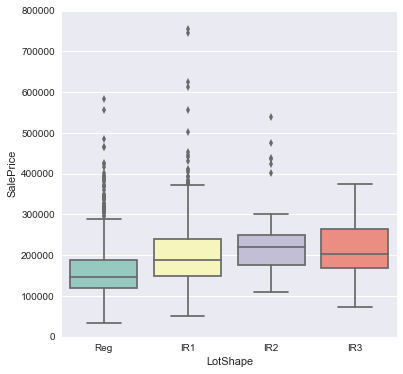

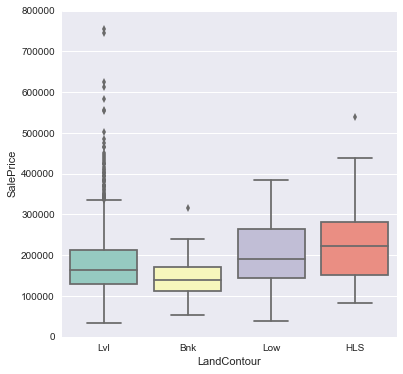

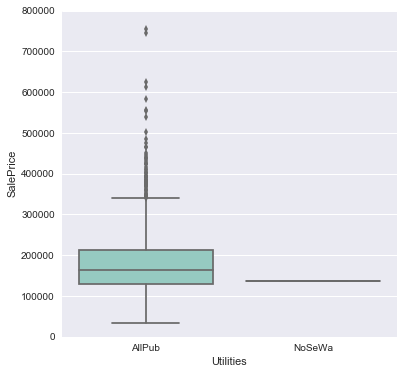

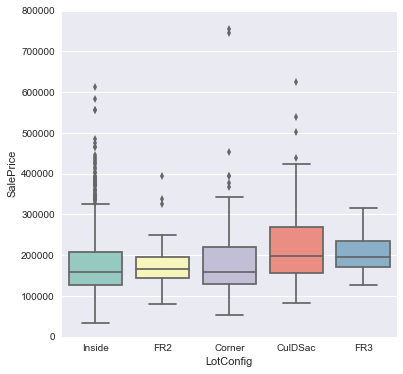

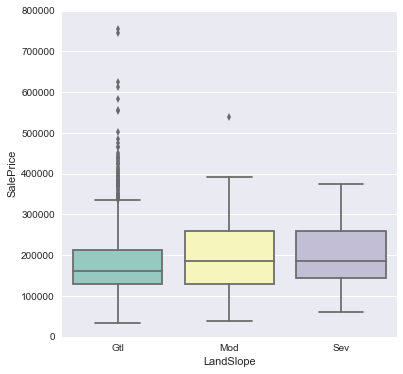

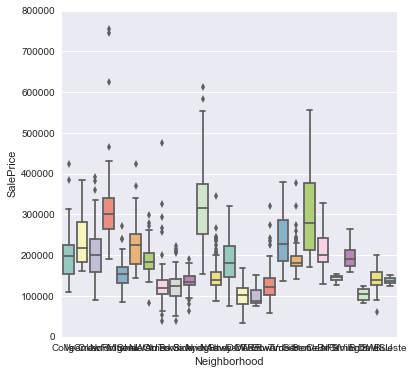

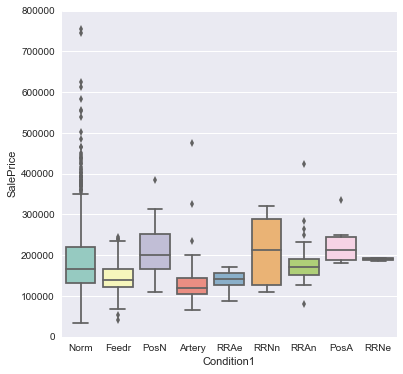

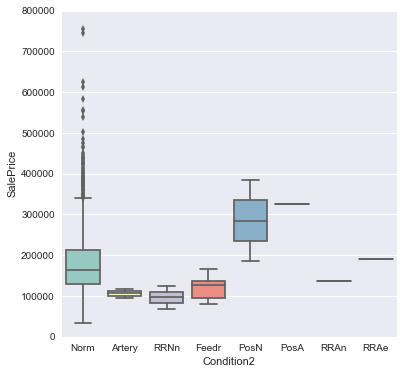

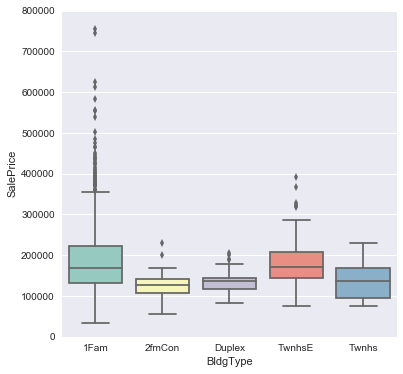

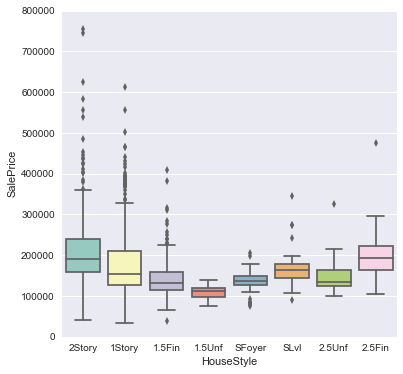

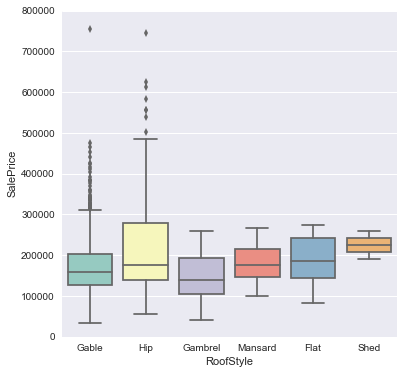

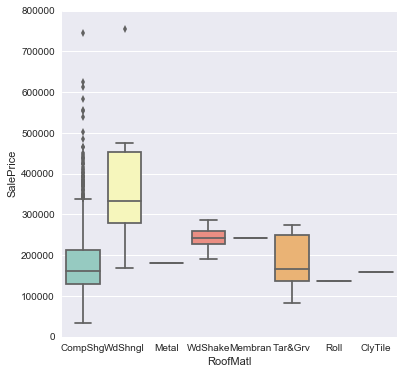

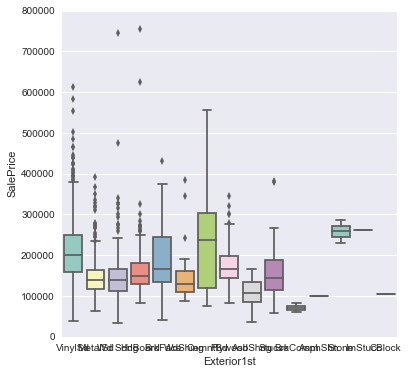

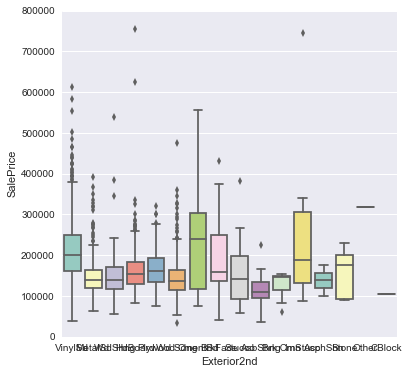

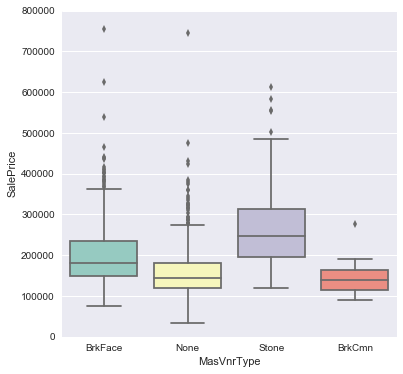

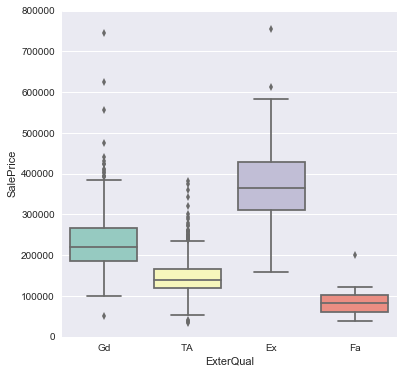

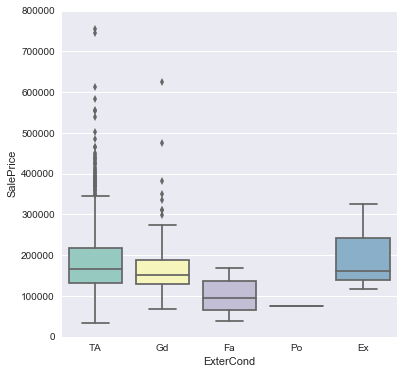

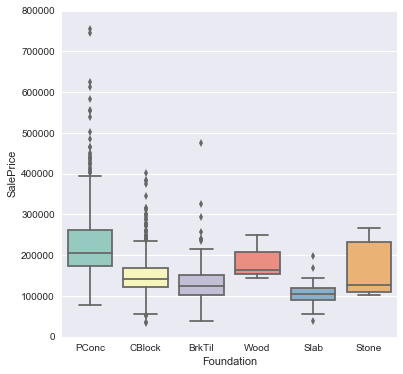

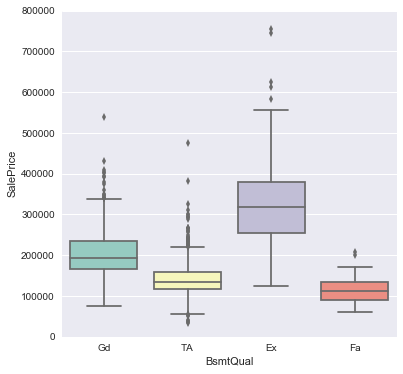

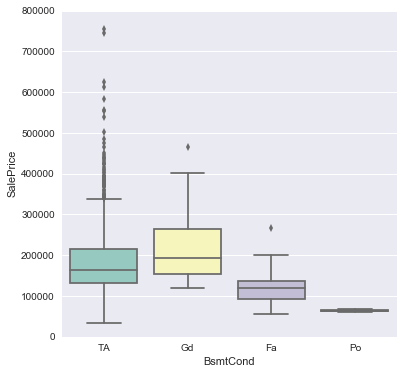

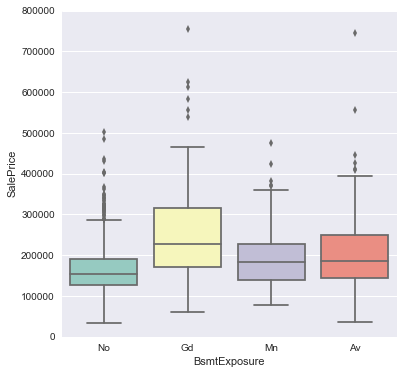

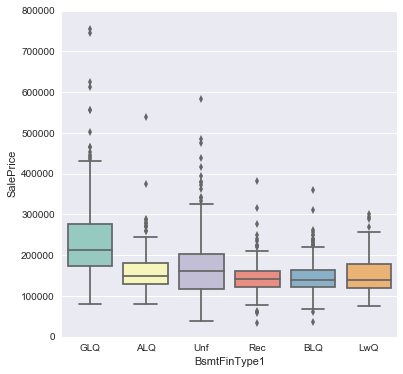

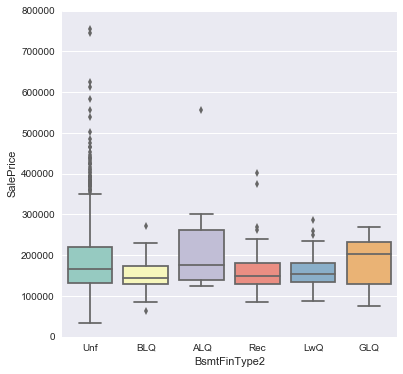

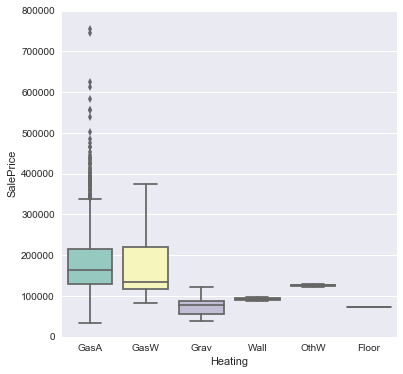

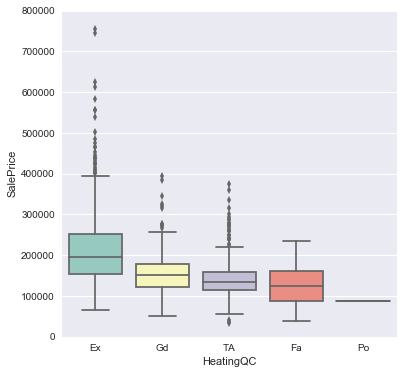

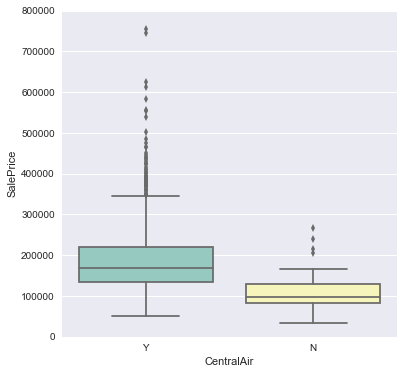

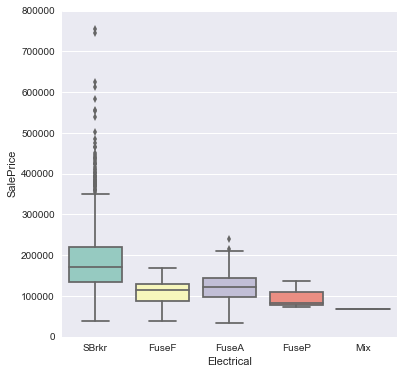

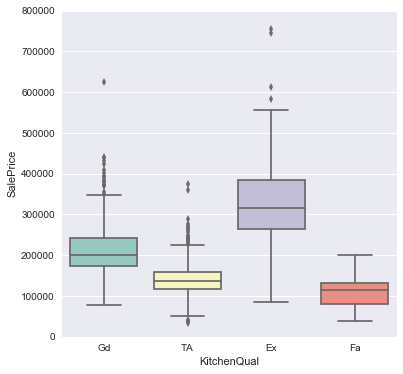

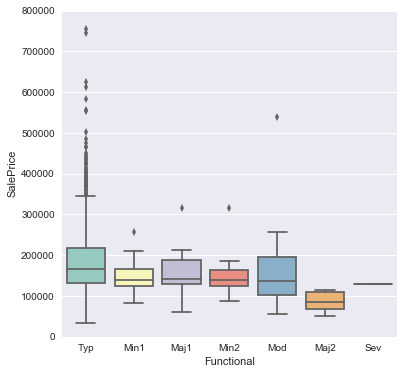

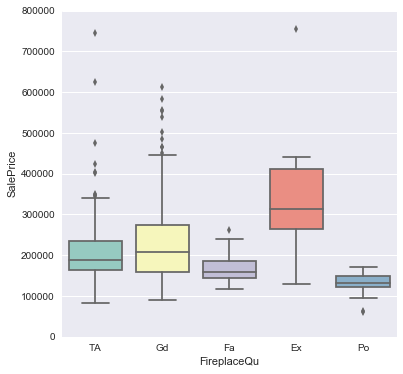

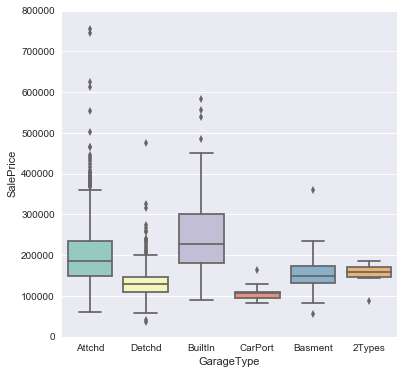

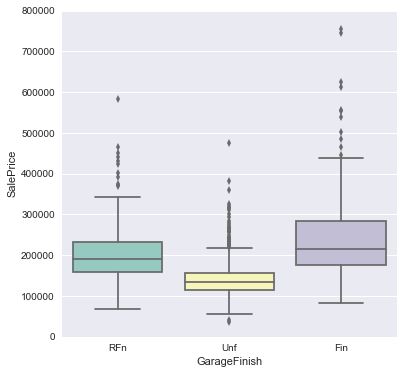

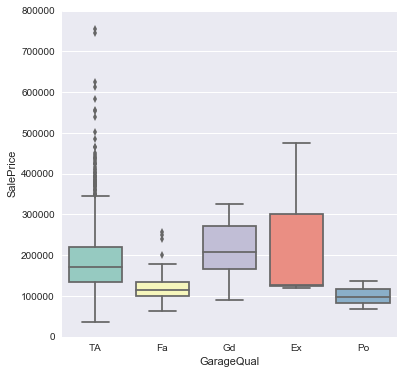

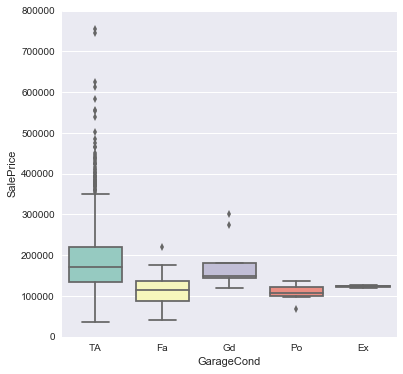

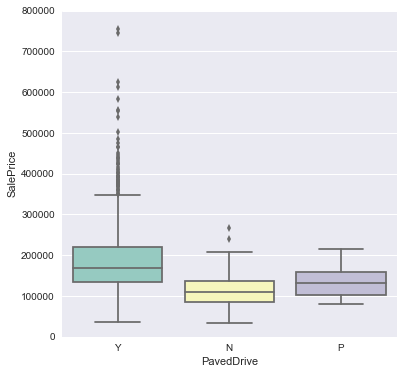

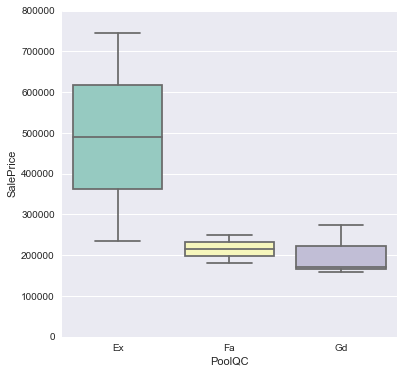

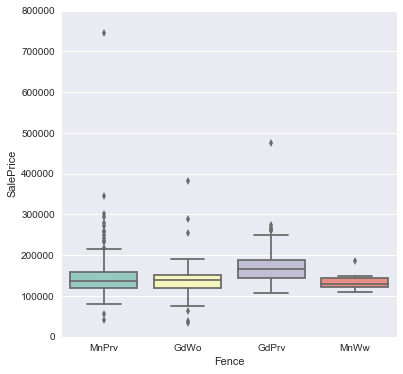

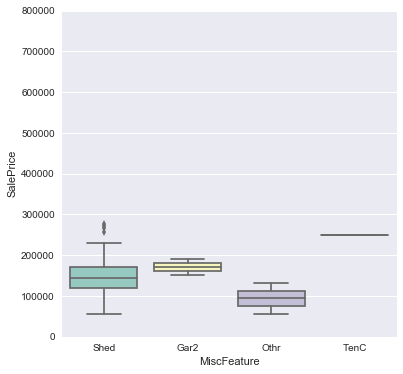

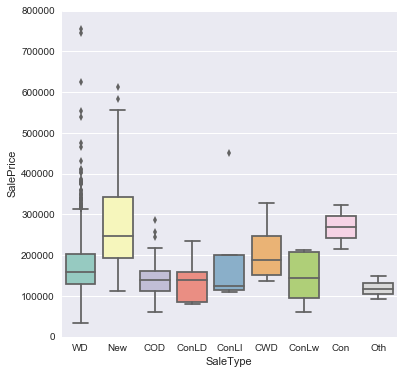

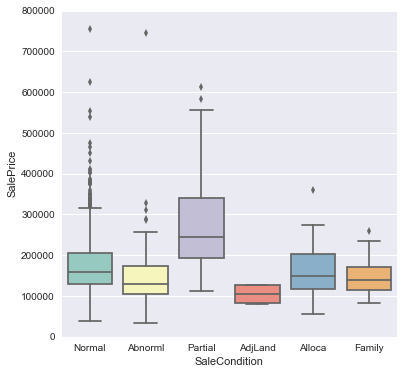

In [76]:
cat_features = train.select_dtypes(include=['object']).columns
for feature in cat_features:
    f,ax=plt.subplots(figsize=(6,6))
    ax = sns.boxplot(x=feature, y="SalePrice",data=train,palette="Set3")
    ax.axis(ymin=0, ymax=800000)

Some categories seem to more diverse with respect to SalePrice than others.The following categorical vars are correlated to sale price, based on eyeball check on box plots: Neighborhood, Condition1, condition2, bldgType,HouseStyle, RoofMatl, Exterior1st,Exteior2nd,ExterQual,ExterCond, Foundation,BsmtQual,BsmtCond,BsmtFinType1,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,SaleType,SaleCondition

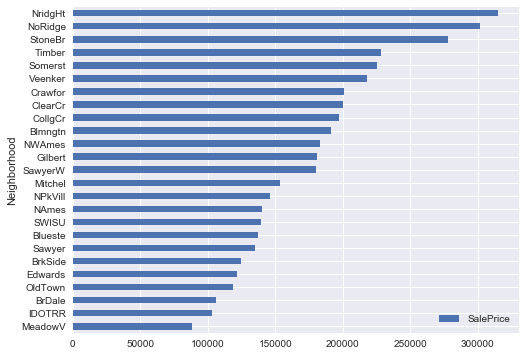

In [77]:
# check sale prices by neighborhood
NbhdPrice = train.groupby('Neighborhood')['SalePrice'].median().sort_values().reset_index()
NbhdPrice.plot(x='Neighborhood', y='SalePrice', kind = 'barh',figsize=(8,6))
ExpsvNbhds = NbhdPrice.loc[NbhdPrice['SalePrice'].nlargest(10).index]['Neighborhood']
CheapNbhds = NbhdPrice.loc[NbhdPrice['SalePrice'].nsmallest(10).index]['Neighborhood']

## Remove outliers

In [78]:
# Create list of potential outliers to examine
potentials = pd.DataFrame()

# For important numeric features, find the data points with extreme high or low values with Tukey method
# Using a generous method here by setting distance as 3 instead of 1.5
for feature in top_cor_feats:
    Q1=np.nanpercentile(train[feature],25)
    Q3=np.nanpercentile(train[feature],75)
    IQR = Q3-Q1
    distance = [(Q1-x)/IQR if x<Q1 else (x-Q3)/IQR if x>Q3 else 0 for x in train[feature]]
    potentials = potentials.append(train.loc[pd.Series(distance)>3])

# Pick records identified as outlier for mutliple times
outliers = potentials.loc[potentials.duplicated(keep = False)]
outliers[top_cor_feats].sort_index()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt
440,555000,10,2402,3,672,3094,2402,2,10,2008
440,555000,10,2402,3,672,3094,2402,2,10,2008
496,430000,8,3228,2,546,3200,3228,3,10,1992
496,430000,8,3228,2,546,3200,3228,3,10,1992
523,184750,10,4676,3,884,3138,3138,3,11,2007
523,184750,10,4676,3,884,3138,3138,3,11,2007
523,184750,10,4676,3,884,3138,3138,3,11,2007
691,755000,10,4316,3,832,2444,2444,3,10,1994
691,755000,10,4316,3,832,2444,2444,3,10,1994
1182,745000,10,4476,3,813,2396,2411,3,10,1996


In [79]:
# Combine the eyeball test and the Tukey test to determine what records to remove
print(train.shape)
train = train.drop(train[train.index==523].index)
train = train.drop(train[train.index==1298].index)
# train = train.drop(train[train.index==691].index)
# train = train.drop(train[train.index==1182].index)
print(train.shape)

(1460, 81)
(1458, 81)


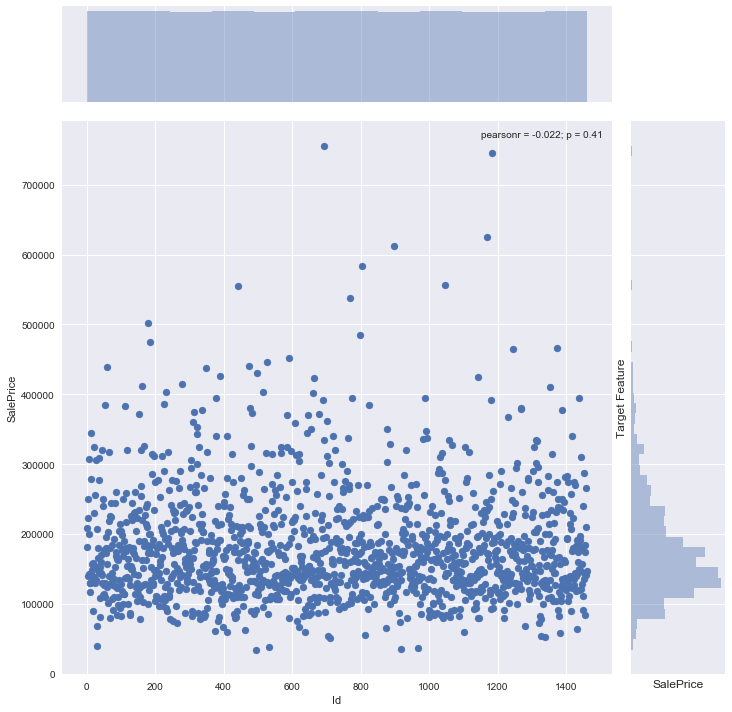

In [80]:
# No meaningful pattern here, implying that Id doesn't contain any helpful information
plt.figure(figsize=(8,8))
sns.jointplot(x= 'Id', y= 'SalePrice', data= train,size=10)
plt.ylabel('Target Feature', fontsize=12)
plt.xlabel('SalePrice', fontsize=12)
plt.show()

## Check out labels

Skewness of the label is 1.881296


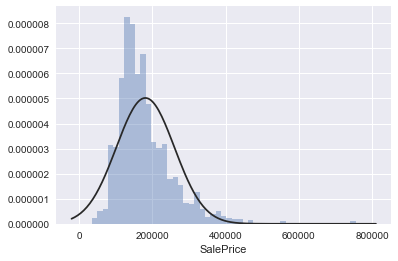

In [81]:
# The distribution of sale price deviates from the normal distribution and positively skewed
sns.distplot(train.SalePrice, fit=norm,kde = False)
print("Skewness of the label is %f" % train['SalePrice'].skew())

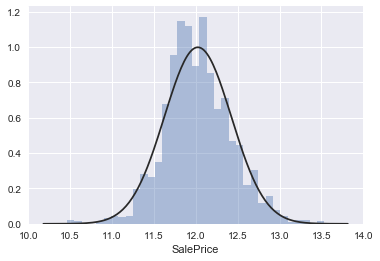

In [82]:
# Log transform the label
saleprice_transformed = np.log(train.SalePrice)
sns.distplot(saleprice_transformed,fit=norm,kde = False)
fig= plt.figure()

## Handle missing data

In [83]:
# Merge train and test df
all_df= pd.concat([train,test],keys=("train","test"))

all_df =all_df.drop("SalePrice",axis=1)
print(all_df.shape)

(2917, 80)


In [84]:
# Check missing data
total = all_df.isnull().sum().sort_values(ascending=False)
pct = (all_df.isnull().sum()/all_df.isnull().count()).sort_values(ascending=False)
NAs = pd.concat([total, pct], axis=1, keys=['Total', 'Percent'])
NAs = NAs[NAs['Total']>=1]
NAs

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageQual,159,0.054508
GarageFinish,159,0.054508
GarageYrBlt,159,0.054508
GarageCond,159,0.054508


In [85]:
for col in NAs.index:
    print('------- Value Counts ------------------')
    print(all_df[col].value_counts())
    print('------- NA Counts ------------------')
    print(NAs.loc[col])

------- Value Counts ------------------
Ex    4
Gd    3
Fa    2
Name: PoolQC, dtype: int64
------- NA Counts ------------------
Total      2908.000000
Percent       0.996915
Name: PoolQC, dtype: float64
------- Value Counts ------------------
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
------- NA Counts ------------------
Total      2812.000000
Percent       0.964004
Name: MiscFeature, dtype: float64
------- Value Counts ------------------
Grvl    120
Pave     78
Name: Alley, dtype: int64
------- NA Counts ------------------
Total      2719.000000
Percent       0.932122
Name: Alley, dtype: float64
------- Value Counts ------------------
MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
------- NA Counts ------------------
Total      2346.000000
Percent       0.804251
Name: Fence, dtype: float64
------- Value Counts ------------------
Gd    742
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64
------- NA C

In [86]:
# Impute NAs

# If confirmed no pool, fill with none; otherwise, fill with average QC
all_df.loc[(all_df['PoolArea']>0) & (all_df['PoolQC'].isnull()),'PoolQC'] = "TA"
all_df.loc[(all_df['PoolArea']==0) & (all_df['PoolQC'].isnull()),'PoolQC'] = "None"
    
# No miscellaneous feature
all_df['MiscFeature'].fillna('None',inplace=True)

# No alley access
all_df['Alley'].fillna('None',inplace=True)

# No fence
all_df['Fence'].fillna('None',inplace=True)

# No fireplace
all_df['FireplaceQu'].fillna('None',inplace=True)

# No garage
all_df['GarageQual'].fillna('None',inplace=True)
all_df['GarageFinish'].fillna('None',inplace=True)
all_df['GarageType'].fillna('None',inplace=True)
all_df['GarageCond'].fillna('None',inplace=True)
all_df['GarageArea'].fillna(0,inplace=True)
all_df['GarageCars'].fillna(0,inplace=True)
all_df['GarageYrBlt'].fillna(0,inplace=True)

# No basement
all_df['BsmtQual'].fillna('None',inplace=True)
all_df['BsmtCond'].fillna('None',inplace=True)
all_df['BsmtExposure'].fillna('None',inplace=True)
all_df['BsmtFinType1'].fillna('None',inplace=True)
all_df['BsmtFinSF1'].fillna(0,inplace=True)
all_df['BsmtFinType2'].fillna('None',inplace=True)
all_df['BsmtFinSF2'].fillna(0,inplace=True)
all_df['BsmtUnfSF'].fillna(0,inplace=True)
all_df['TotalBsmtSF'].fillna(0,inplace=True)
all_df['BsmtFullBath'].fillna(0,inplace=True)
all_df['BsmtHalfBath'].fillna(0,inplace=True)

# Masonry veneer - fill with the most common type - None
all_df['MasVnrType'].fillna('None',inplace=True)
all_df['MasVnrArea'].fillna(0,inplace=True)

# Utilities - fill with the most common type - AllPub
all_df['Utilities'].fillna('AllPub',inplace=True)

# Functional - fill with the most common type - Typ
all_df['Functional'].fillna('Typ',inplace=True)

# Electrical - fill with the most common type - SBrkr
all_df['Electrical'].fillna('SBrkr',inplace=True)

# KitchenQual - fill with the most common type - TA
all_df['KitchenQual'].fillna('TA',inplace=True)

# Exterior(1 missing) - fill with the most common type - VinylSd
all_df['Exterior1st'].fillna('VinylSd',inplace=True)
all_df['Exterior2nd'].fillna('VinylSd',inplace=True)

# SaleType(1 missing) - fill with the most common type - WD
all_df['SaleType'].fillna('WD',inplace=True)


# Check if all NAs are imputed
all_NAs = all_df.isnull().sum()
all_NAs = all_NAs[all_NAs>0]
print('Features with Missing Values are:', all_NAs.index.values)

Features with Missing Values are: ['LotFrontage' 'MSZoning']


In [87]:
# Do more exploration to fill LotFrontage and MSZoning

# LotFrontage: Linear feet of street connected to property (486 missing records) 
nolf = all_df[all_df['LotFrontage'].isnull()][['Id','LotFrontage','LotArea','Neighborhood']]
medianlf = all_df.groupby('Neighborhood')['LotFrontage'].median().reset_index()
medianlf.rename(columns = {'LotFrontage':'Nbhd_median_lf'}, inplace= True)

# # Get LotFrontage/LotArea ratio and fill NAs by the median ratio of the neighorhood
# all_df['LotRatio'] = all_df['LotFrontage']/all['LotArea']
# lotratio = all_df.groupby('Neighborhood')['LotRatio'].median().reset_index()
# lotratio.rename(columns = {'LotRatio':'Nbhd_LotRatio'}, inplace= True)

nolf = pd.merge(nolf,medianlf,how='left',on ='Neighborhood')
nolf['LotFrontage'].fillna((nolf['Nbhd_median_lf']),inplace=True)
all_df.loc[all_df['Id'].isin(nolf['Id']), ['LotFrontage']] = nolf['LotFrontage'].values


# MSZoning (4 missing records)
# Try to find the zoning code based on neighborhood
print(all_df[all_df.MSZoning.isnull()][['MSZoning','Neighborhood']])
print(all_df[all_df['Neighborhood']=='IDOTRR']['MSZoning'].value_counts())
print(all_df[all_df['Neighborhood']=='Mitchel']['MSZoning'].value_counts())

# Fill with the most common zoing code based on the neighborhood
all_df.loc[(all_df['MSZoning'].isnull()) & (all_df['Neighborhood']=='IDOTRR') , 'MSZoning'] = "RM"
all_df.loc[(all_df['MSZoning'].isnull()) & (all_df['Neighborhood']=='Mitchel'), 'MSZoning'] = "RL"

# Check if all NAs are imputed
all_NAs = all_df.isnull().sum()
all_NAs = all_NAs[all_NAs>0]
print('Features with Missing Values are:', all_NAs.index.values)

          MSZoning Neighborhood
test 455       NaN       IDOTRR
     756       NaN       IDOTRR
     790       NaN       IDOTRR
     1444      NaN      Mitchel
RM         68
C (all)    22
Name: MSZoning, dtype: int64
RL    104
RM      9
Name: MSZoning, dtype: int64
Features with Missing Values are: []


## Feature Engineering

In [88]:
# Convert some categorical variables to ordinal
qual_dict = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
all_df["GarageQual"] = all_df["GarageQual"].map(qual_dict).astype(int)
all_df["GarageCond"] = all_df["GarageCond"].map(qual_dict).astype(int)
all_df["BsmtQual"] = all_df["BsmtQual"].map(qual_dict).astype(int)
all_df["BsmtCond"] = all_df["BsmtCond"].map(qual_dict).astype(int)
all_df["PoolQC"] = all_df["PoolQC"].map(qual_dict).astype(int)
all_df["HeatingQC"] = all_df["HeatingQC"].map(qual_dict).astype(int)
all_df["KitchenQual"] = all_df["KitchenQual"].map(qual_dict).astype(int)
all_df["FireplaceQu"] = all_df["FireplaceQu"].map(qual_dict).astype(int)
all_df["ExterQual"] = all_df["ExterQual"].map(qual_dict).astype(int)
all_df["ExterCond"] = all_df["ExterCond"].map(qual_dict).astype(int)


all_df["BsmtExposure"] = all_df["BsmtExposure"].replace({"None":0,"No":1,"Mn":2,"Av":3,"Gd":4})
all_df["BsmtFinType1"] = all_df["BsmtFinType1"].replace({"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6})
all_df["BsmtFinType2"] = all_df["BsmtFinType2"].replace({"None":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6})
all_df["GarageFinish"] = all_df["GarageFinish"].replace({"None":0,"Unf":1,"RFn":2,"Fin":3})
all_df["Fence"] = all_df["Fence"].replace({"None":0,"MnWw":1,"GdWo":2,"MnPrv":3,"GdPrv":4})
all_df["Functional"] = all_df["Functional"].replace({"None":0,"Sal":1,"Sev":2,"Maj2":3,"Maj1":3,"Mod":4,
                                                     "Min1":5,"Min2":5,"Typ":6})

# Convert some numeric variables to categorical
# MSSubClass: Identifies the type of dwelling involved in the sale
all_df["MSSubClass"] = "MSSC" + all_df["MSSubClass"].astype(str)


In [89]:
# # Create a bunch of binary features

# If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
all_df["Remodeled"] = (all_df["YearRemodAdd"] != all_df["YearBuilt"]) * 1

# Did a remodeling happen in the year the house was sold?
all_df["RecentRemodel"] = (all_df["YearRemodAdd"] == all_df["YrSold"]) * 1

# Has masonry veneer or not
all_df["HasMasVnr"] = all_df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                 "Stone" : 1, "None" : 0})

# Was this house sold in the year it was built?
all_df["NewHouse"] = (all_df["SaleType"] == 'New') * 1

# House completed before sale or not
all_df["BoughtOffPlan"] = all_df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                        "Family" : 0, "Normal" : 0, "Partial" : 1})

new_cond_feats = ['Remodeled','RecentRemodel','HasMasVnr','NewHouse','BoughtOffPlan']
all_df[new_cond_feats].describe()

,Remodeled,RecentRemodel,HasMasVnr,NewHouse,BoughtOffPlan
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,0.465547,0.081248,0.394583,0.081248,0.083305
std,0.498897,0.273262,0.488845,0.273262,0.276390
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [90]:
# # Create combined variables

# Overall quality of the house
all_df["OverallGrade"] = all_df["OverallQual"] * all_df["OverallCond"]
# Overall quality of the garage
all_df["GarageGrade"] = all_df["GarageQual"] * all_df["GarageCond"]
# Overall quality of the exterior
all_df["ExterGrade"] = all_df["ExterQual"] * all_df["ExterCond"]
# Overall kitchen score
all_df["KitchenScore"] = all_df["KitchenAbvGr"] * all_df["KitchenQual"]
# Overall fireplace score
all_df["FireplaceScore"] = all_df["Fireplaces"] * all_df["FireplaceQu"]
# Overall garage score
all_df["GarageScore"] = all_df["GarageArea"] * all_df["GarageQual"]
# Overall pool score
all_df["PoolScore"] = all_df["PoolArea"] * all_df["PoolQC"]
# Total number of bathrooms
all_df["TotalBath"] = all_df["BsmtFullBath"] + (0.5 * all_df["BsmtHalfBath"]) + \
all_df["FullBath"] + (0.5 * all_df["HalfBath"])
# Total SF for house (incl. basement)
all_df["AllSF"] = all_df["GrLivArea"] + all_df["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
all_df["AllFlrsSF"] = all_df["1stFlrSF"] + all_df["2ndFlrSF"]
# Total Finish SF for basement
all_df['AllFinBsmtSF'] = all_df['BsmtFinSF1'] + all_df['BsmtFinSF2']
all_df['PctFinBsmtSF'] = all_df['AllFinBsmtSF']/all_df['TotalBsmtSF']
all_df['PctFinBsmtSF'].fillna(0,inplace=True)
# Total SF for porch
all_df["AllPorchSF"] = all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + \
all_df["3SsnPorch"] + all_df["ScreenPorch"]

comb_feats = ["OverallGrade","GarageGrade","ExterGrade","KitchenScore","FireplaceScore",
              "GarageScore","PoolScore","TotalBath","AllSF","AllFlrsSF","AllFinBsmtSF","AllPorchSF"]
all_df[comb_feats].describe()

,OverallGrade,GarageGrade,ExterGrade,KitchenScore,FireplaceScore,GarageScore,PoolScore,TotalBath,AllSF,AllFlrsSF,AllFinBsmtSF,AllPorchSF
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,33.724717,8.349674,10.484402,3.642098,2.057251,1407.880357,7.577648,2.216832,2547.219403,1493.553994,488.464176,89.071649
std,9.179470,2.311875,2.171374,0.845457,2.327258,665.559948,129.298569,0.806907,782.027723,494.463943,466.583030,107.714739
min,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,334.000000,334.000000,0.000000,0.000000
25%,30.000000,9.000000,9.000000,3.000000,0.000000,936.000000,0.000000,1.500000,2004.000000,1120.000000,0.000000,0.000000
50%,35.000000,9.000000,9.000000,4.000000,1.000000,1434.000000,0.000000,2.000000,2452.000000,1440.000000,456.000000,50.000000
75%,40.000000,9.000000,12.000000,4.000000,4.000000,1728.000000,0.000000,2.500000,2995.000000,1742.000000,804.000000,136.000000
max,90.000000,25.000000,25.000000,9.000000,15.000000,5392.000000,3200.000000,7.000000,10190.000000,5095.000000,4010.000000,1207.000000


In [91]:
# Neightborhood level var
vars = ['LotArea','OverallGrade','GarageScore','TotalBath','AllSF','AllFlrsSF','AllPorchSF','YearBuilt','ExterGrade','TotalBsmtSF','BsmtUnfSF']
nbhd_vars = all_df.groupby('Neighborhood')[vars].median().reset_index()
cols = ['Neighborhood']+['{}_{}'.format('nbhd_median',v) for v in vars]
nbhd_vars.columns=cols
all_df = pd.merge(all_df,nbhd_vars, how='left',on='Neighborhood')
all_df[vars].head()

,LotArea,OverallGrade,GarageScore,TotalBath,AllSF,AllFlrsSF,AllPorchSF,YearBuilt,ExterGrade,TotalBsmtSF,BsmtUnfSF
0,8450,35,1644.0,3.5,2566.0,1710,61,2003,12,856.0,150.0
1,9600,48,1380.0,2.5,2524.0,1262,0,1976,9,1262.0,284.0
2,11250,35,1824.0,3.5,2706.0,1786,42,2001,12,920.0,434.0
3,9550,35,1926.0,2.0,2473.0,1717,307,1915,9,756.0,540.0
4,14260,40,2508.0,3.5,3343.0,2198,84,2000,12,1145.0,490.0


In [92]:
# Year and Month
# Year position 
min_year = all_df['YearBuilt'].min()
max_year = all_df['YearBuilt'].max()
all_df['YearBuilt_pos']=all_df['YearBuilt'].apply(lambda x:np.float64((x-min_year+1))/(max_year-min_year+1))

all_df.groupby('MoSold')['Id'].count()
all_df['HotSeason'] = all_df['MoSold'].replace({1:0,2:0,3:1,4:1,5:1,6:1,7:1,8:1,9:0,10:0,11:0,12:0})

# Create year bin
year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
all_df["GarageYrBltBin"] = all_df.GarageYrBlt.map(year_map)
all_df["GarageYrBltBin"].fillna('None',inplace=True)
all_df['YrSoldBin'] = all_df.YrSold.map(year_map)
all_df['YearRemodAddBin'] = all_df.YearRemodAdd.map(year_map)

In [93]:
# Polynomials on the most important numeric features
feats_to_poly = comb_feats # add comb vars here

poly_feats=[]
for feature in feats_to_poly:
    all_df[feature+'2'] = all_df[feature]**2
    poly_feats.append(feature+'2')

all_df[poly_feats].head()

,OverallGrade2,GarageGrade2,ExterGrade2,KitchenScore2,FireplaceScore2,GarageScore2,PoolScore2,TotalBath2,AllSF2,AllFlrsSF2,AllFinBsmtSF2,AllPorchSF2
0,1225,81,144,16,0,2702736.0,0,12.25,6584356.0,2924100,498436.0,3721
1,2304,81,81,9,9,1904400.0,0,6.25,6370576.0,1592644,956484.0,0
2,1225,81,144,16,9,3326976.0,0,12.25,7322436.0,3189796,236196.0,1764
3,1225,81,81,16,16,3709476.0,0,4.00,6115729.0,2948089,46656.0,94249
4,1600,81,144,16,9,6290064.0,0,12.25,11175649.0,4831204,429025.0,7056


In [94]:
# Differentiate numerical features and categorical features
num_feats = all_df.select_dtypes(exclude=['object']).columns
cat_feats = all_df.select_dtypes(include=["object"]).columns
print("Numeric Features: %d" %len(num_feats))
print("Categorical Features: %d" %len(cat_feats))
cat_feats

Numeric Features: 95
Categorical Features: 31


Index(['Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType',
       'Heating', 'HouseStyle', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities', 'GarageYrBltBin', 'YrSoldBin',
       'YearRemodAddBin'],
      dtype='object')

In [95]:
# Log transform of the skewed numerical features to lessen impact of outliers
skewed_feats = all_df[num_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.50]
skewed_feats = skewed_feats.index
print("number of skewed features is %d" %(len(skewed_feats)))
all_df[skewed_feats] = np.log1p(all_df[skewed_feats])
all_df[skewed_feats].head()

number of skewed features is 59


,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,...,ExterGrade2,KitchenScore2,FireplaceScore2,GarageScore2,PoolScore2,TotalBath2,AllSF2,AllFlrsSF2,AllFinBsmtSF2,AllPorchSF2
0,6.753438,6.751101,0.0,0.693147,6.561031,0.0,0.693147,0.693147,0.000000,5.017280,...,4.976734,2.833213,0.000000,14.809776,0.0,2.583998,15.700207,14.888498,13.119232,8.222016
1,7.141245,0.000000,0.0,1.609438,6.886532,0.0,0.693147,0.000000,0.693147,5.652489,...,4.406719,2.302585,2.302585,14.459678,0.0,1.981001,15.667201,14.280907,13.771020,0.000000
2,6.825460,6.765039,0.0,1.098612,6.188264,0.0,0.693147,0.693147,0.000000,6.075346,...,4.976734,2.833213,2.302585,15.017575,0.0,2.583998,15.806454,14.975468,12.372421,7.475906
3,6.869014,6.629363,0.0,0.693147,5.379897,0.0,0.693147,0.693147,0.000000,6.293419,...,4.406719,2.833213,2.833213,15.126401,0.0,1.609438,15.626375,14.896668,10.750578,11.453706
4,7.044033,6.960348,0.0,1.386294,6.486161,0.0,0.693147,0.693147,0.000000,6.196444,...,4.976734,2.833213,2.302585,15.654482,0.0,2.583998,16.229248,15.390606,12.969273,8.861775


In [96]:
# One hot encoding
# Create dummy variable for categorical features
all_data = pd.get_dummies(all_df)

In [97]:
all_data =all_data.drop("Id",axis=1)
all_data.shape

(2917, 302)

## Modeling

In [98]:
train_X = all_data.iloc[:train.shape[0]]
test_X = all_data.iloc[train.shape[0]:]
train_y = saleprice_transformed
train_Y = train_y.ravel()

print(train_X.shape)
print(test_X.shape)
print(len(train_y))

(1458, 302)
(1459, 302)
1458


In [99]:
# Standardize the features
train_X = StandardScaler().fit_transform(train_X)
test_X = StandardScaler().fit_transform(test_X)

### PCA - Dimensionality Reduction

In [100]:
pca = PCA(n_components=None)
train_X_PCA = pca.fit_transform(train_X)
test_X_PCA = pca.fit_transform(test_X)
explained_variance = pca.explained_variance_ratio_
np.cumsum(explained_variance)

array([ 0.11167732,  0.15555722,  0.18519802,  0.21366524,  0.23792748,
        0.26063729,  0.27884601,  0.29514624,  0.31052474,  0.32473049,
        0.33849094,  0.3519415 ,  0.36417111,  0.37588567,  0.38722275,
        0.3981668 ,  0.40891842,  0.41929747,  0.42917825,  0.43873387,
        0.44801388,  0.4571404 ,  0.46587836,  0.47455027,  0.48300476,
        0.49138558,  0.4996885 ,  0.50762036,  0.51539202,  0.52294064,
        0.53043388,  0.53768583,  0.54486965,  0.55197992,  0.55896433,
        0.56589117,  0.57258694,  0.57915089,  0.58562852,  0.59199469,
        0.59830119,  0.60441678,  0.61040828,  0.61635747,  0.62222296,
        0.62802727,  0.63362827,  0.6391509 ,  0.64458813,  0.64997061,
        0.6553207 ,  0.66059676,  0.6657789 ,  0.67094891,  0.6760267 ,
        0.68107872,  0.68606365,  0.69095715,  0.69574654,  0.70043957,
        0.70508977,  0.70968616,  0.71425359,  0.71879284,  0.72329804,
        0.72774803,  0.73213879,  0.73648439,  0.74072912,  0.74

In [101]:
# Splitting
x_train, x_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

In [102]:
# Define model evaluation function
def cv_rmse_train(estimator):
    rmse= np.sqrt(-cross_val_score(estimator, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
def cv_rmse_test(estimator):
    rmse= np.sqrt(-cross_val_score(estimator, x_test, y_test, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### XGBoost Base Model for Feature Selection

In [103]:
# Use sklearn API here cuz it's easy to get feature importance
import xgboost as xgb
base = xgb.XGBRegressor(
                 colsample_bytree=0.8,
                 learning_rate=0.2,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=200,                                                                  
                 subsample=0.8,
                 seed=3)

base.fit(train_X,train_y)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(base).mean(),cv_rmse_train(base).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(base).mean(),cv_rmse_test(base).std()))

RMSE (Training data): 0.1307 +/- 0.0139
RMSE (Validation data): 0.1467 +/- 0.0110


XGB model: 195 features are picked and 107 features are dropped


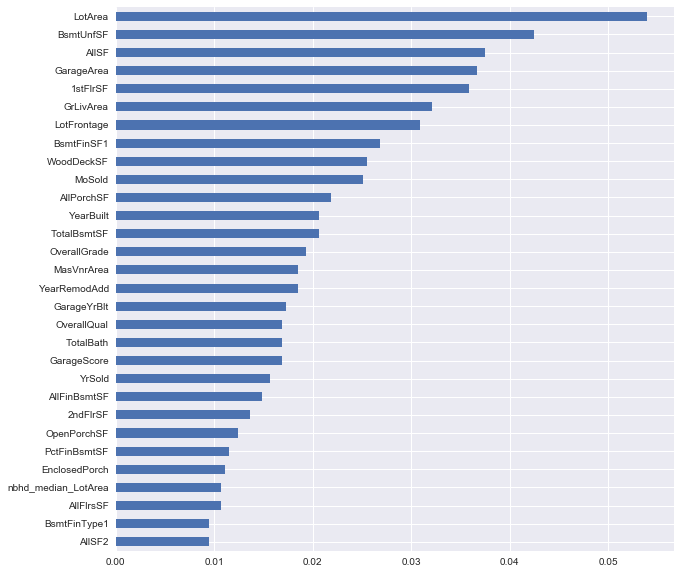

In [104]:
coefs = pd.Series(base.feature_importances_,index= all_data.columns)
print("XGB model: %s features are picked and %s features are dropped" % (sum(coefs != 0),sum(coefs == 0)))
imp_coefs = coefs.sort_values().tail(30)
imp_coefs.plot(kind = "barh",figsize=(10,10))

### Linear Regression with Ridge regularization (L2 penalty)

In [105]:
ridge_cv = RidgeCV(alphas = np.arange(0.1,501,10)).fit(x_train, y_train)
rg_best_alpha =ridge_cv.alpha_
print("Best alpha :", rg_best_alpha)

Best alpha : 390.1


In [106]:
ridge = Ridge(alpha=rg_best_alpha).fit(x_train, y_train)
print("Final ridge model:")
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(ridge).mean(),cv_rmse_train(ridge).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(ridge).mean(),cv_rmse_test(ridge).std()))

Final ridge model:
RMSE (Training data): 0.1182 +/- 0.0102
RMSE (Validation data): 0.1296 +/- 0.0152


### Linear Regression with Lasso regularization (L1 penalty)

In [107]:
# Fit Lasso model
lasso_cv = LassoCV(alphas =np.arange(0.0005,0.01,0.0001)).fit(x_train, y_train)
ls_best_alpha = lasso_cv.alpha_
print("Best alpha :", ls_best_alpha)

Best alpha : 0.0031


In [108]:
lasso =Lasso(alpha=ls_best_alpha).fit(x_train, y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(lasso).mean(),cv_rmse_train(lasso).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(lasso).mean(),cv_rmse_test(lasso).std()))

RMSE (Training data): 0.1167 +/- 0.0109
RMSE (Validation data): 0.1286 +/- 0.0069


Lasso model: 116 features are picked and 186 features are dropped


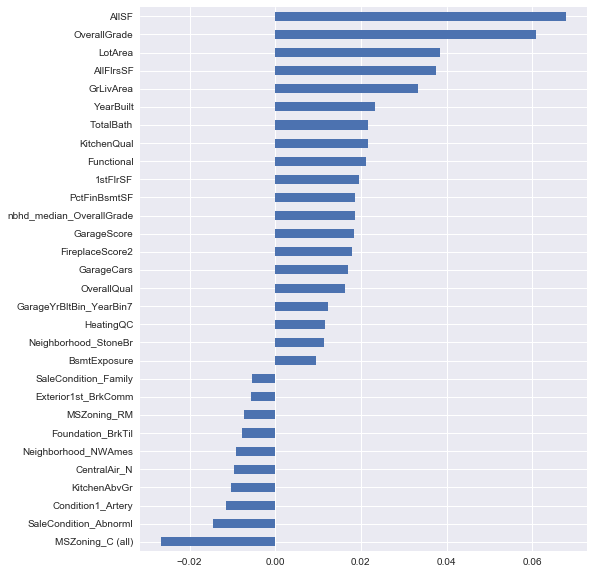

In [109]:
# # Plot important coefficients
coefs = pd.Series(lasso.coef_,index=all_data.columns)
print("Lasso model: %s features are picked and %s features are dropped" % (sum(coefs != 0),sum(coefs == 0)))
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(20)])
imp_coefs.plot(kind = "barh",figsize=(8,10))

### Elastic Net Model (L1 and L2 penalty)

Elastic Net is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso, such as the number of variables (Lasso can't select more features than it has observations, but it's not the case here anyway).

In [110]:
enet_cv = ElasticNetCV(alphas=np.arange(0.001,1,0.002), l1_ratio=(0.01,0.99,0.005)).fit(x_train, y_train)
en_best_alpha = enet_cv.alpha_
en_best_l1_ratio = enet_cv.l1_ratio_
print("Best alpha :", en_best_alpha)
print("Best L1 ratio :", en_best_l1_ratio)

Best alpha : 0.213
Best L1 ratio : 0.01


In [111]:
enet = ElasticNet(alpha=en_best_alpha,l1_ratio=en_best_l1_ratio).fit(x_train,y_train)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(enet).mean(),cv_rmse_train(enet).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(enet).mean(),cv_rmse_test(enet).std()))

RMSE (Training data): 0.1165 +/- 0.0111
RMSE (Validation data): 0.1250 +/- 0.0106


Elastic Net model: 181 features are picked and 121 features are dropped


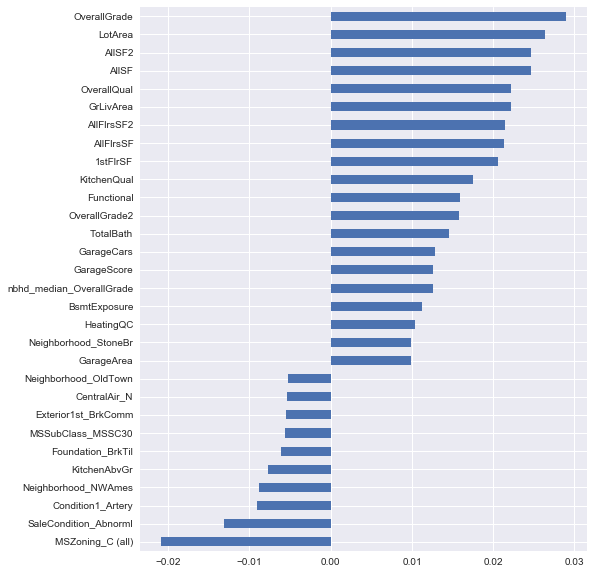

In [112]:
# Plot important coefficients
coefs = pd.Series(enet.coef_,index=all_data.columns)
print("Elastic Net model: %s features are picked and %s features are dropped" % (sum(coefs != 0),sum(coefs == 0)))
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(20)])
imp_coefs.plot(kind = "barh",figsize=(8,10))

## SVM

In [113]:
from sklearn import svm
svr = svm.SVR(C=0.8,kernel='rbf')
svr.fit(train_X, train_y)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(svr).mean(),cv_rmse_train(svr).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(svr).mean(),cv_rmse_test(svr).std()))

RMSE (Training data): 0.1879 +/- 0.0189
RMSE (Validation data): 0.2021 +/- 0.0378


## Gredient Boosting

In [114]:
# Define paramater tuning function
def param_tuning(estimator, params_grid):
    starttime=time.time()
    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="neg_mean_squared_error", n_jobs= -1)
    model.fit(train_X,train_y)
    best_model = model.best_estimator_
    print("------------------------------")
    print(model.best_params_)
    print("RMSE (Training data): {}".format(np.sqrt(-model.best_score_)))
    print("------------------------------")
    print("Task running time: %.2f seconds" %(time.time()-starttime))
    return best_model

In [115]:
# GB baseline
gb0 = GradientBoostingRegressor(n_estimators = 100,learning_rate =0.2,random_state=0)
gb0.fit(train_X,train_y)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(gb0).mean(),cv_rmse_train(gb0).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(gb0).mean(),cv_rmse_test(gb0).std()))

RMSE (Training data): 0.1292 +/- 0.0090
RMSE (Validation data): 0.1384 +/- 0.0144


In [116]:
parameters = {'max_depth':np.arange(2,6,1),
              'max_features':np.arange(0.2,0.6,0.1),              
              'min_samples_split':np.arange(30,91,10),
              'min_samples_leaf':np.arange(2,11,2)
             }
gb1 = param_tuning(gb0,parameters)

------------------------------
{'min_samples_leaf': 4, 'min_samples_split': 80, 'max_depth': 3, 'max_features': 0.50000000000000011}
RMSE (Training data): 0.11632591718371105
------------------------------
Task running time: 397.62 seconds


In [118]:
# Final GB model
gb = GradientBoostingRegressor(n_estimators=1000, 
                                learning_rate =0.01,
                                max_depth=3, 
                                max_features= 0.5,
                                min_samples_split =80,
                                min_samples_leaf =4,                                 
                                random_state=0)
gb.fit(train_X,train_y)
print("RMSE (Training data): %.4f +/- %.4f" % (cv_rmse_train(gb).mean(),cv_rmse_train(gb).std()))
print("RMSE (Validation data): %.4f +/- %.4f" % (cv_rmse_test(gb).mean(),cv_rmse_test(gb).std()))

RMSE (Training data): 0.1232 +/- 0.0110
RMSE (Validation data): 0.1323 +/- 0.0148


Gredient Boosting model: 144 features are picked and 158 features are dropped


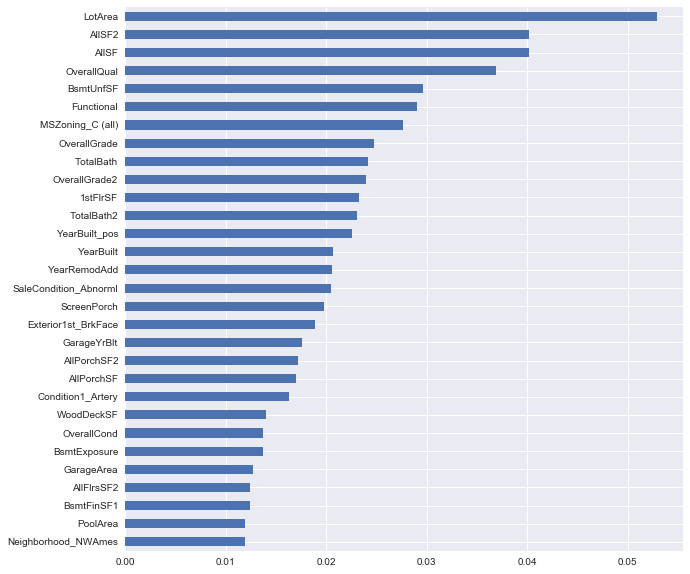

In [119]:
coefs = pd.Series(gb.feature_importances_,index= all_data.columns)
print("Gredient Boosting model: %s features are picked and %s features are dropped" % (sum(coefs != 0),sum(coefs == 0)))
imp_coefs = coefs.sort_values().tail(30)
imp_coefs.plot(kind = "barh",figsize=(10,10))

## XGBoost

In [120]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
xgtrain = xgb.DMatrix(train_X, label=train_Y)

start_time = time.time()
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['eta'] = 0.1
    params['max_depth'] = int(max_depth)   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = True    


    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round=100000,
                       nfold=5,
                       metrics={'rmse'},
                       seed=3,
                       callbacks=[xgb.callback.early_stop(50)])

    return cv_result['test-rmse-mean'].min()


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (3, 13),
                              'min_child_weight': (0, 100),
                              'colsample_bytree': (0.2, 1),
                              'subsample': (0.3, 1),
                              'gamma': (0, 2)
                             }
                            )
xgb_BO.maximize(init_points=5, n_iter=20)

print('task running time: %d' %(time.time()-start_time))

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[181]	train-rmse:0.145216+0.00166305	test-rmse:0.155107+0.00619411

    1 | 00m09s |    0.15511 |             0.3060 |    1.6347 |      8.2611 |            23.6910 |      0.5851 | 
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[321]	train-rmse:0.158869+0.00129991	test-rmse:0.164336+0.00996862

    2 | 00m22s |    0.16434 |             0.8811 |    1.5371 |     11.2486 |            92.3652 |      0.5060 | 
Multiple eval metrics have been passed: 'test-rmse' will be 

In [121]:
## Display tuning results
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=True)
xgb_BO_scores.head()

,colsample_bytree,gamma,max_depth,min_child_weight,subsample,score
4,0.231487,2.000000,13.000000,39.040702,1.000000,0.157760
5,0.215403,1.966731,3.123153,0.507524,0.547502,0.158000
8,0.231776,1.948146,3.044608,59.971842,0.691563,0.158811
1,0.324861,1.990233,3.053987,76.810199,0.948477,0.159373
10,0.245732,1.937033,3.150978,37.756130,0.523585,0.161621


In [122]:
xgb_parameters=[]
for p in xgb_BO_scores.head(2).iterrows():
    xgb_parameters.append({
                  'max_depth':int(p[1].to_dict()['max_depth']),
                  'min_child_weight':int(p[1].to_dict()['min_child_weight']),
                  'colsample_bytree':p[1].to_dict()['colsample_bytree'],
                  'subsample':p[1].to_dict()['subsample'],
                  'gamma':p[1].to_dict()['gamma'],
                  'seed':3,
                  'nthread':-1        
                    })
xgb_parameters

[{'colsample_bytree': 0.2314869333871731,
  'gamma': 2.0,
  'max_depth': 12,
  'min_child_weight': 39,
  'nthread': -1,
  'seed': 3,
  'subsample': 1.0},
 {'colsample_bytree': 0.21540265866676478,
  'gamma': 1.9667312329671791,
  'max_depth': 3,
  'min_child_weight': 0,
  'nthread': -1,
  'seed': 3,
  'subsample': 0.54750168555470657}]

## Ensembling

In [123]:
NFOLDS = 5
SEED = 0

train_Y = train_y.ravel() # 1* matrix to *1 matrix (long to wide)
ntrain = len(train_X)
ntest = len(test_X)

# KFold from model selection package and cross validation package is different. This is from the cv package
kf = KFold(ntrain, n_folds = NFOLDS, shuffle=True, random_state=SEED)

In [124]:
class SklearnWrapper(object):
    
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed # add new attribute random_state in the params object
        self.clf = clf(**params) # set parameter in the classifier

    def train(self, train_X, train_Y):
        self.clf.fit(train_X, train_Y)

    def predict(self, x):
        return self.clf.predict(x)
    

In [125]:
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds',10000) 
        # pop(key, default) removes and returns last object or obj from the dictionary
        # if nrounds is specified in params, then remove it from the dictionary 
        # and pass it to the nrounds object with a default value of 250

    def train(self, train_X, train_Y):
        dtrain = xgb.DMatrix(train_X, label=train_Y)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x): # x here should be np array
        return self.gbdt.predict(xgb.DMatrix(x))
    

In [126]:
def get_oof(clf): # get out of fold
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = train_X[train_index] # train folds
        y_tr = train_Y[train_index]
        x_te = train_X[test_index] # oof
        
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te) # oof train prediction
        oof_test_skf[i, :] = clf.predict(test_X) # test set prediction
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [127]:
ls_params={
    'alpha': 0.003
}

rg_params={
    'alpha': 420
}

gb_params = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'max_depth': 3,
    'max_features':0.5,
    'min_samples_split': 80,
    'min_samples_leaf': 4    
}


In [128]:
ls = SklearnWrapper(clf=Lasso, seed=SEED, params=ls_params)
rg = SklearnWrapper(clf=Ridge, seed=SEED, params=rg_params)
gb = SklearnWrapper(clf=GradientBoostingRegressor, seed=SEED, params=gb_params)
xg = XgbWrapper(seed=SEED, params=xgb_parameters[0])
print(xgb_parameters[0])

{'max_depth': 12, 'min_child_weight': 39, 'nthread': -1, 'gamma': 2.0, 'subsample': 1.0, 'seed': 0, 'colsample_bytree': 0.2314869333871731}


In [129]:
import xgboost as xgb
start_time=time.time()

ls_oof_train, ls_oof_test = get_oof(ls)
rg_oof_train, rg_oof_test = get_oof(rg)
gb_oof_train, gb_oof_test = get_oof(gb)
xg_oof_train, xg_oof_test = get_oof(xg)

print('Time elapsed: %.2f seconds' %(time.time()-start_time))

Time elapsed: 475.79 seconds


In [130]:
print("LS-CV: {}".format(np.sqrt(mean_squared_error(train_Y, ls_oof_train))))
print("RG-CV: {}".format(np.sqrt(mean_squared_error(train_Y, rg_oof_train))))
print("GB-CV: {}".format(np.sqrt(mean_squared_error(train_Y, gb_oof_train))))
print("XG-CV: {}".format(np.sqrt(mean_squared_error(train_Y, xg_oof_train))))


LS-CV: 0.11380108759219933
RG-CV: 0.1152065786550978
GB-CV: 0.11744399750505136
XG-CV: 0.16547467440835223


In [131]:
# LS-CV: 0.1117484584043736
# RG-CV: 0.11196697247988244
# EN-CV: 0.12180171651968114
# GB-CV: 0.11388158733439077
# XG-CV: 0.11571401737279516
# ET-CV: 0.1344297179707636
# RF-CV: 0.13141634301758012

In [132]:
tr_X = np.concatenate((ls_oof_train,rg_oof_train,gb_oof_train,xg_oof_train), axis=1)
te_X = np.concatenate((ls_oof_test,rg_oof_test,gb_oof_test,xg_oof_test), axis=1)
print("{},{}".format(tr_X.shape, te_X.shape))

(1458, 4),(1459, 4)


### 2nd level model: Elastic Net

In [133]:
# 2nd level Elastic Net
enet_cv = ElasticNetCV(alphas=np.arange(0.001,1,0.002), l1_ratio=(0.01,0.99,0.005)).fit(tr_X, train_Y)
en_best_alpha = enet_cv.alpha_
en_best_l1_ratio = enet_cv.l1_ratio_
print("Best alpha :", en_best_alpha)
print("Best L1 ratio :", en_best_l1_ratio)

Best alpha : 0.001
Best L1 ratio : 0.01


In [134]:
enet = ElasticNet(alpha=en_best_alpha,l1_ratio=en_best_l1_ratio)
rmse= np.sqrt(-cross_val_score(enet, tr_X,train_Y, scoring="neg_mean_squared_error", cv = 5))
print('RMSE:',rmse.mean())

RMSE: 0.110540151456


In [135]:
enet = enet.fit(tr_X,train_Y)
enet_pred = np.exp(enet.predict(te_X))
enet_pred[:10]

array([ 124063.88077156,  162081.82434596,  187042.44152374,
        201550.95081745,  201705.39496212,  174894.56083911,
        181420.33514044,  168080.8035668 ,  186585.23600773,
        121026.3193867 ])

### 2nd level model: XGBoost

In [136]:
dtrain = xgb.DMatrix(tr_X, label=train_Y)
dtest = xgb.DMatrix(te_X)

In [137]:
xgb_params = {
    'seed': 3,
    'learning_rate': 0.01,
    'max_depth': 13,
    'min_child_weight': 4,    
    'colsample_bytree': 0.3, 
    'subsample': 0.2,  
    'gamma':0.1,
    'eval_metric': 'rmse',   
    'silent': 1,
}

In [138]:
res = xgb.cv(xgb_params, dtrain, num_boost_round=3000, nfold=NFOLDS, seed=SEED, stratified=False,
             early_stopping_rounds=25, verbose_eval=100, show_stdv=True)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

print('best_nrounds: {}'.format(best_nrounds))
print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))

[0]	train-rmse:11.4159+0.0046099	test-rmse:11.4159+0.0185048
[100]	train-rmse:4.21303+0.00212917	test-rmse:4.21298+0.0192526
[200]	train-rmse:1.56973+0.0011807	test-rmse:1.56973+0.0122501
[300]	train-rmse:0.596189+0.000664126	test-rmse:0.597112+0.00875094
[400]	train-rmse:0.248312+0.0010365	test-rmse:0.251285+0.00530243
[500]	train-rmse:0.139587+0.00223922	test-rmse:0.145515+0.00806064
[600]	train-rmse:0.114607+0.00287412	test-rmse:0.122119+0.0114698
[700]	train-rmse:0.109539+0.00303345	test-rmse:0.11775+0.0126206
[800]	train-rmse:0.108044+0.00287676	test-rmse:0.116912+0.0131351
best_nrounds: 803
Ensemble-CV: 0.11689960000000002+0.013152538030357493


In [139]:
gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
xgb_pred = np.exp(gbdt.predict(dtest))
xgb_pred[:10]

array([ 121417.4921875,  158627.765625 ,  179344.359375 ,  194016.640625 ,
        199083.75     ,  168405.828125 ,  171645.3125   ,  166629.34375  ,
        172193.578125 ,  118414.1953125], dtype=float32)

In [142]:
final_label = 1 * enet_pred + 0 * xgb_pred

print(final_label[:10])
pd.DataFrame({'Id': test.Id, 'SalePrice': final_label}).to_csv('.csv', index =False) 

[ 124063.88077156  162081.82434596  187042.44152374  201550.95081745
  201705.39496212  174894.56083911  181420.33514044  168080.8035668
  186585.23600773  121026.3193867 ]
